In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
# import xgcm

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43935,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.76 GiB
Comm: tcp://127.0.0.1:41319,Total threads: 1
Dashboard: http://127.0.0.1:33297/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:40237,


In [3]:
import datetime
import nc_time_axis

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
import matplotlib.path as mpath

In [34]:
Bprime_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-BUOY_prime/*2014*BUOYprime.nc"

Bprime_REF= xr.open_mfdataset(Bprime_data_filesREF, parallel=True,decode_times=False,concat_dim='time_counter', combine='nested')

In [36]:
Bprime_REF.deptht

<xarray.DataArray 'deptht' (deptht: 75)> Size: 300B
array([5.057600e-01, 1.555855e+00, 2.667682e+00, 3.856280e+00, 5.140361e+00,
       6.543034e+00, 8.092519e+00, 9.822750e+00, 1.177368e+01, 1.399104e+01,
       1.652532e+01, 1.942980e+01, 2.275762e+01, 2.655830e+01, 3.087456e+01,
       3.574020e+01, 4.118002e+01, 4.721189e+01, 5.385064e+01, 6.111284e+01,
       6.902168e+01, 7.761116e+01, 8.692943e+01, 9.704131e+01, 1.080303e+02,
       1.200000e+02, 1.330758e+02, 1.474062e+02, 1.631645e+02, 1.805499e+02,
       1.997900e+02, 2.211412e+02, 2.448906e+02, 2.713564e+02, 3.008875e+02,
       3.338628e+02, 3.706885e+02, 4.117939e+02, 4.576256e+02, 5.086399e+02,
       5.652923e+02, 6.280260e+02, 6.972587e+02, 7.733683e+02, 8.566790e+02,
       9.474479e+02, 1.045854e+03, 1.151991e+03, 1.265861e+03, 1.387377e+03,
       1.516364e+03, 1.652568e+03, 1.795671e+03, 1.945296e+03, 2.101027e+03,
       2.262422e+03, 2.429025e+03, 2.600380e+03, 2.776039e+03, 2.955570e+03,
       3.138565e+03, 3.324641e+03, 3.513446e+03, 3.704657e+03, 3.897982e+03,
       4.093159e+03, 4.289953e+03, 4.488155e+03, 4.687581e+03, 4.888070e+03,
       5.089479e+03, 5.291683e+03, 5.494575e+03, 5.698061e+03, 5.902058e+03],
      dtype=float32)
Coordinates:
  * deptht   (deptht) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Attributes:
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds

In [5]:
Wprime_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-gridW_prime/*gridWprime.nc"
Wprime_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-gridW_prime/*gridWprime.nc"

In [6]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [7]:
grid_files = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc"
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
mask_file= "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc"


In [8]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coords = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
mask = xr.open_mfdataset(mask_file, parallel=True, preprocess=prepro)

In [9]:
Wprime_REF = xr.open_mfdataset(Wprime_data_filesREF, preprocess=prepro, parallel=True)
Wprime_REF = Wprime_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})
Wprime_REF = Wprime_REF.chunk({"x":395,"y":501})

In [10]:
Wprime_FUT= xr.open_mfdataset(Wprime_data_filesFUT, preprocess=prepro, parallel=True)
Wprime_FUT = Wprime_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})
Wprime_FUT = Wprime_FUT.chunk({"x":395,"y":501})

In [11]:
data_test = Wprime_REF.isel(x=slice(500,510),y=slice(400,410),time_counter=slice(0,10))

In [12]:
def interp_vertically(ds):
    interp = (ds + np.roll(ds,-1,axis=0))/2
    return interp

def interp_ufunc(data):
    interp = xr.apply_ufunc(interp_vertically, data, input_core_dims=[["time_counter","x","y"]], output_core_dims=[["time_counter","x","y"]], 
            dask="allowed", vectorize = True)
    return interp
    

In [ ]:
output = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-gridW_prime_interp/"

for time in Wprime_REF.time_counter:
    date = (str(time.values)[0:10])
    print(date)
    year,month,day = date.split("-")
    
    data = Wprime_REF.sel(time_counter=date)
    interp_data = interp_ufunc(data)
    interp_data["depthw"] = grid.nav_lev.values
    interp_data.to_netcdf(output+"CREG12.L75-REF08_y{0}m{1}d{2}.5d_gridWprime.nc".format(year,month,day))

In [ ]:
output = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-gridW_prime_interp/"

for time in Wprime_FUT.time_counter:
    date = (str(time.values)[0:10])
    print(date)
    year,month,day = date.split("-")
    
    data = Wprime_FUT.sel(time_counter=date)
    interp_data = interp_ufunc(data)
    interp_data["depthw"] = grid.nav_lev.values
    interp_data.to_netcdf(output+"CREG12.L75-FUT08_y{0}m{1}d{2}.5d_gridWprime.nc".format(year,month,day))

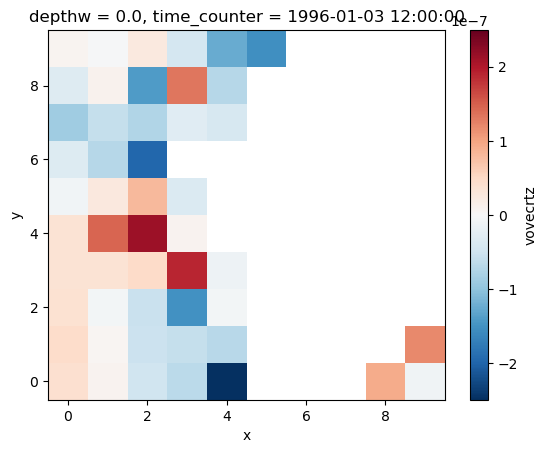

In [61]:
(data_test - filtered).vovecrtz.isel(depthw=0,time_counter=0).plot()

In [62]:
test = (data_test.isel(depthw=0)+data_test.isel(depthw=1))/2

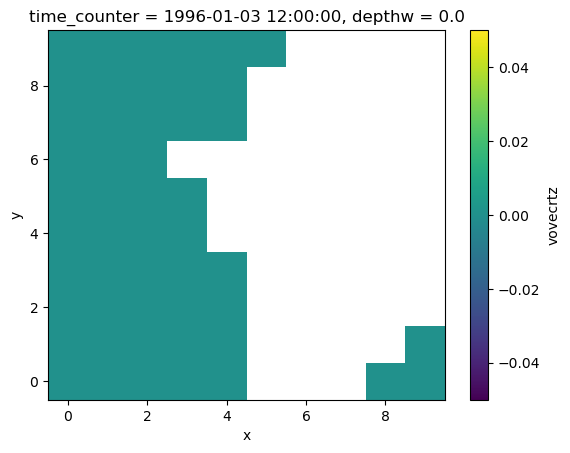

In [64]:
(test - filtered.isel(depthw=0)).isel(time_counter=0).vovecrtz.plot()